# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [90]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

In [91]:
data = pd.read_csv('train.csv')

In [92]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [93]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [94]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

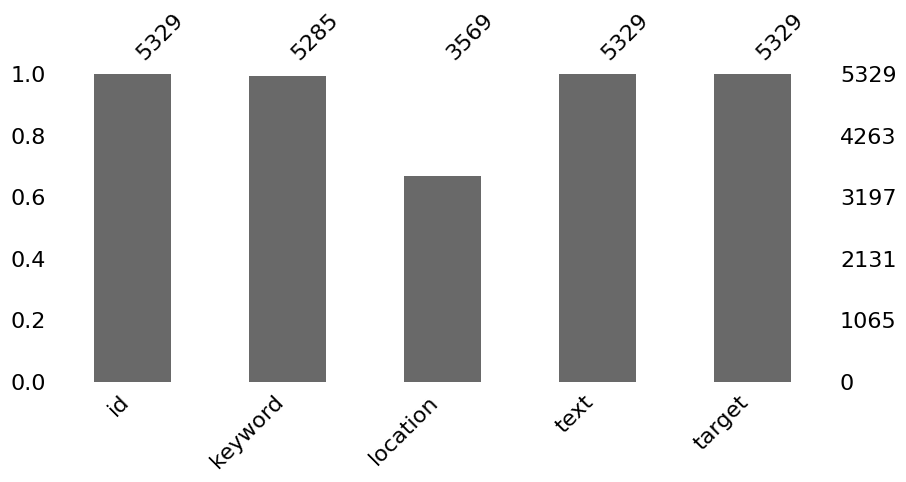

In [95]:
import missingno as msno

# визаулизируем количество не пропущенных значений
msno.bar(train, figsize=(10, 4));

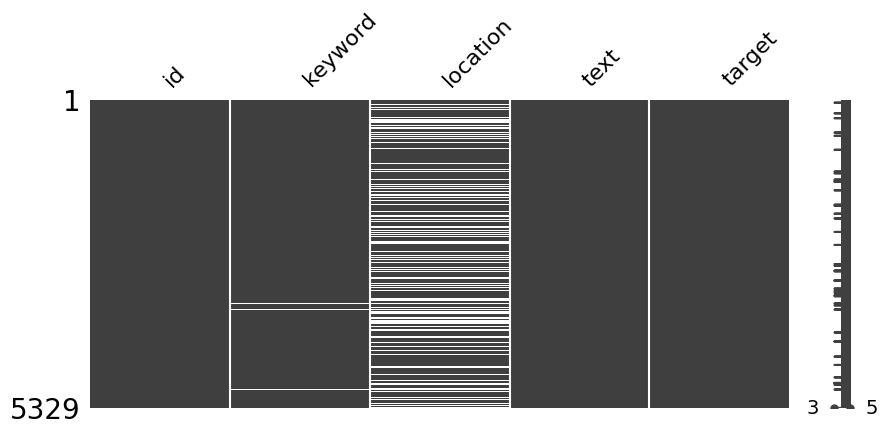

In [96]:
# визаулизируем пропуски для каждого признака
msno.matrix(train, figsize=(10, 4));

In [97]:
train.loc[train['keyword'].isna(), 'keyword'] = ''
train.loc[train['location'].isna(), 'location'] = ''

In [98]:
test.isnull().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [99]:
test.loc[test['keyword'].isna(), 'keyword'] = ''
test.loc[test['location'].isna(), 'location'] = ''

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?

Распределение классов можно считать сбалансированным


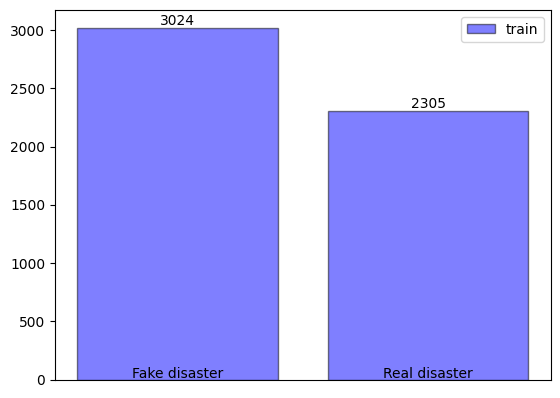

In [100]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(train['target'].values, bins=2, alpha=0.5, label='train', color='blue', edgecolor='black', linewidth=1, rwidth=0.8)

bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_counts = [f'{int(count)}' for count in n]
labels = ['Fake disaster', 'Real disaster' ]

for i, (count, x, label) in enumerate(zip(bin_counts, bin_centers, labels)):
    ax.text(x, -10, label, ha='center', va='bottom')
    ax.text(x, n[i], count, ha='center', va='bottom')

# plt.xticks(False)
ax.set_xticks([])
plt.legend()
plt.show()

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [101]:
train['keyword'].value_counts()

                         44
damage                   36
siren                    35
wreckage                 34
fatalities               33
                         ..
rescue                   16
epicentre                10
radiation%20emergency     7
inundation                7
threat                    6
Name: keyword, Length: 222, dtype: int64

In [102]:
top_10 = train['keyword'].value_counts().head(10)
popular_keywords = top_10.index
top_10

              44
damage        36
siren         35
wreckage      34
fatalities    33
deluge        31
refugees      30
derail        30
fear          30
tsunami       30
Name: keyword, dtype: int64

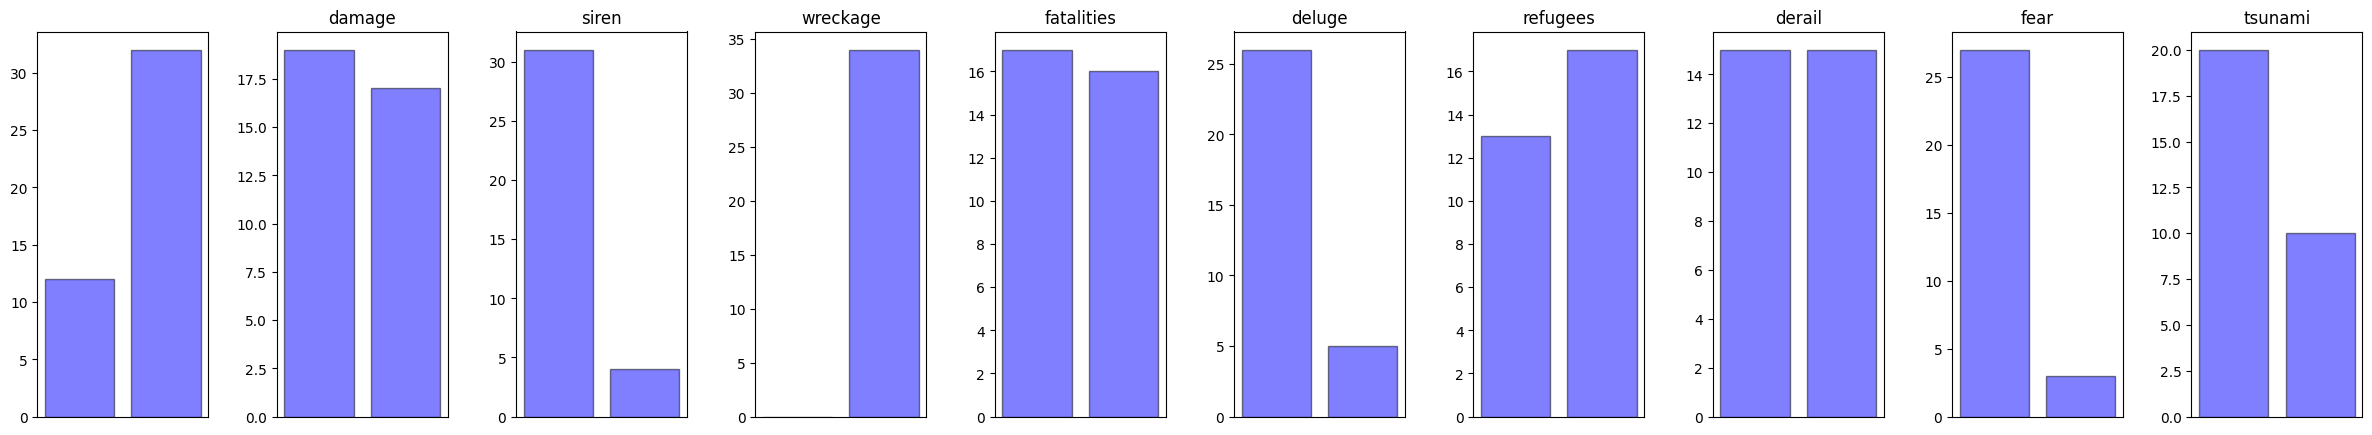

In [103]:
# по отдельности

fig, ax = plt.subplots(nrows=1, ncols=len(top_10), figsize=(30, 5))

for i, key_word in enumerate(popular_keywords):
    n, bins, patches = ax[i].hist(train[train['keyword'] == key_word]['target'].values, bins=2, alpha=0.5, color='blue', edgecolor='black', linewidth=1, rwidth=0.8)
    
    ax[i].set_xticks([])
    ax[i].set_title(key_word)

plt.subplots_adjust(wspace=0.4)
plt.show()


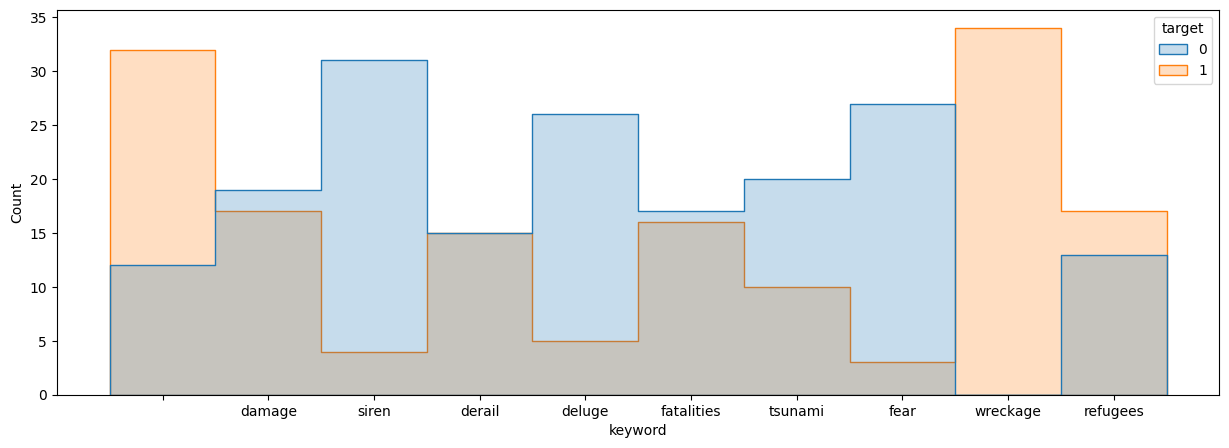

In [104]:
# вместе

plt.figure(figsize=(15, 5))
sns.histplot(train[train['keyword'].isin(popular_keywords)], x="keyword", hue="target", element="step")
plt.show()

**Выводы**: Среди популярных слов чаще всего встречается пропуск (то есть пустая строка). Также для категории werkage вообще нет фейковых сообщений (видимо так люди выражают свое недовольство по поводу РАБоты, но такое соотношение, понятно, сильно зависит от размеров выборки, а она у нас очень маленькая), а для всех остальных количество твитов о ложных бедствиях не меньше, чем правдивых, кроме категории refugees.

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [105]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [106]:
train_new = train.copy()
cat = train_new.select_dtypes(include=['object']).columns.tolist()

def f(x):
    string = ''
    for i in range(len(x)):
        string += x.iloc[i] + ' '
    return string[:-1]

train_new['text'] = train_new[cat].apply(f, axis=1)
train_new.drop(columns=set(cat + ['id']) - set(['text']), inplace=True)

In [107]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


In [108]:
test_new = test.copy()
cat = test_new.select_dtypes(include=['object']).columns.tolist()

test_new['text'] = test_new[cat].apply(f, axis=1)
test_new.drop(columns=set(cat + ['id']) - set(['text']), inplace=True)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [109]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer()
count_matrix = cv.fit_transform(train_new['text']).toarray()
count_matrix.shape

(5329, 18455)

In [110]:
count_matrix.shape

(5329, 18455)

In [111]:
df = pd.DataFrame(data=count_matrix, columns = cv.get_feature_names_out())
df

,00,000,0000,00cy9vxeff,00end,00pm,01,011072,014213,02,...,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûò800000,ûó,ûóher,ûókody,ûótech
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Размер матрицы составил 5329 $\times$ 18455. Это не очень хорошо, так как получилось, что количество признаков в более чем три раза превышает количество объектов в нашей обучающей выборке при такой токенизации.

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле `vocabulary_` инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [112]:
import re, string

def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    # return any(c.isdigit() for c in s)
    return bool(re.search(r'\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(char in string.punctuation for char in s)

def is_hashtag_(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention_(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    d = np.zeros(4)
    for word in vocabulary:
        d += np.array([
            contains_digit(word),
            contains_punctuation(word),
            is_hashtag_(word),
            is_mention_(word)])

    print('With digit:      ', d[0]
          )
    print('With punctuation:', d[1]
          )
    print('Hashtags:        ', d[2]
          )
    print('Mentions:        ', d[-1]
          )




In [113]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2.0
With punctuation: 7.0
Hashtags:         1.0
Mentions:         3.0


In [114]:
investigate_vocabulary(cv.vocabulary_)

With digit:       3812.0
With punctuation: 315.0
Hashtags:         0.0
Mentions:         0.0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [115]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [116]:
cv_tweet = CountVectorizer(tokenizer=TweetTokenizer().tokenize)

count_matrix = cv_tweet.fit_transform(train_new['text']).toarray()
count_matrix.shape

(5329, 19670)

In [117]:
investigate_vocabulary(cv_tweet.vocabulary_)

With digit:       3939.0
With punctuation: 7338.0
Hashtags:         1470.0
Mentions:         1679.0


**Сравнение:** Токенизация прошла намного лучше (это видно даже по количеству слов в каждой категории). Также лучше получились размечены слова с хештегом и упоминанием.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены, содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer


[interesting](https://personal.eur.nl/frasincar/papers/SAC2013b/sac2013b.pdf) [links](https://arxiv.org/ftp/arxiv/papers/1511/1511.02556.pdf)

In [118]:
import nltk


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [119]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return bool(re.fullmatch('[a-zA-Z]+', s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом

    # Тут коряво написана регулярка (зато работает, вроде: https://regex101.com/r/cO8lqs/29475)

    # для объяснения: [string.punctuation]+[#all_brackets]+|[#all_brackets]+[string.punctuation]+

    # Instead see https://www.regular-expressions.info/lookaround.html
    # parentheses = r'[)({}\[\]]'
    # regex = r"""(?=.*\b!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\b)(?=.*\b[)({}\[\]]+|[)({}\[\]]\b).+$"""

    # return bool(re.fullmatch(r"""[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]+[)({}\[\]]+|[)({}\[\]]+[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]+""", s))
    return bool(re.fullmatch(r"""[!\"#$%&'()*+,-.\/:;<=>?@[\]^_`{|}~]+[)({}\[\]]+|[)({}\[\]]+[!\"#$%&'()*+,-.\/:;<=>?@[\]^_`{|}~]+""", s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return is_hashtag_(s)

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()

    tk = TweetTokenizer()
    tokens = np.array(tk.tokenize(s))

    m1 = np.array([contains_only_latin_letters(word) for word in tokens])
    m2 = np.array([is_emoji(word) for word in tokens])
    m3 = np.array([is_hashtag(word) and contains_only_latin_letters(word[1:]) for word in tokens])
    
    stop_words = set(stopwords.words('english'))
    m4 = np.array([not (word in stop_words) for word in tokens])

    mask = m1 + m2 + m3 + m4
    prep_tk = tokens[mask] 
    
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in prep_tk]
    return stemmed_tokens
    

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [120]:
[custom_tokenizer(t) for t in train_new['text'][0:10]]

[['bridg',
  '%',
  '20collaps',
  'ash',
  '2015',
  ':',
  'australia',
  '\x89',
  'ûªs',
  'collaps',
  'at',
  'trent',
  'bridg',
  'among',
  'worst',
  'in',
  'histori',
  ':',
  'england',
  'bundl',
  'out',
  'australia',
  'for',
  '60',
  '...',
  'http://t.co/t5trhjuau0'],
 ['hail',
  'carol',
  'stream',
  ',',
  'illinoi',
  'great',
  'michigan',
  'techniqu',
  'camp',
  'b1g',
  'thank',
  'to',
  '@bmurph1019',
  '@hail_youtsey',
  '.',
  '@termn8r13',
  '#goblu',
  '#wrestleon',
  'http://t.co/oaskgki6qj'],
 ['polic',
  'houston',
  'cnn',
  ':',
  'tennesse',
  'movi',
  'theater',
  'shoot',
  'suspect',
  'kill',
  'by',
  'polic',
  'http://t.co/di8elzswnr'],
 ['riot',
  'still',
  'riot',
  'in',
  'a',
  'coupl',
  'of',
  'hour',
  'left',
  'until',
  'i',
  'have',
  'to',
  'be',
  'up',
  'for',
  'class',
  '.'],
 ['wound',
  'lake',
  'highland',
  'crack',
  'in',
  'the',
  'path',
  'where',
  'i',
  'wipe',
  'out',
  'this',
  'morn',
  'dure',
 

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [121]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
vectorizer.fit(train_new['text'])

count_matrix_train = vectorizer.transform(train_new['text']).toarray()
count_matrix_train.shape

(5329, 17122)

In [122]:
investigate_vocabulary(vectorizer.vocabulary_)

# видно, что кастомный токенайзер справился лучше, чем CountVectorizer с дефолтным токенайзером

With digit:       3934.0
With punctuation: 7102.0
Hashtags:         1448.0
Mentions:         1679.0


2. Обучите LogisticRegression на полученных признаках.


In [123]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(count_matrix_train, train_new['target'])

print(f"Train score {lr.score(count_matrix_train, train_new['target'])}")

Train score 0.9771063989491462


3. Посчитайте метрику f1-score на тестовых данных.

In [124]:
from sklearn.metrics import f1_score

count_matrix_test = vectorizer.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(count_matrix_test))}")

F1 test score: 0.7597402597402597


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)
vectorizer_tfidf.fit(train_new['text'])

count_matrix_train = vectorizer_tfidf.transform(train_new['text']).toarray()
count_matrix_train.shape

(5329, 17122)

In [126]:
investigate_vocabulary(vectorizer_tfidf.vocabulary_)

With digit:       3934.0
With punctuation: 7102.0
Hashtags:         1448.0
Mentions:         1679.0


In [127]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(count_matrix_train, train_new['target'])

print(f"Train score {lr.score(count_matrix_train, train_new['target'])}")

Train score 0.881215987990242


In [128]:
from sklearn.metrics import f1_score

count_matrix_test = vectorizer_tfidf.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(count_matrix_test))}")

F1 test score: 0.744083654375344


1. **Ответ:** качество ухудшилось...

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [129]:
vectorizer_tfidf_90 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
vectorizer_tfidf_90.fit(train_new['text'])

count_matrix_train_90 = vectorizer_tfidf_90.transform(train_new['text']).toarray()
count_matrix_train_90.shape

(5329, 17122)

In [130]:
investigate_vocabulary(vectorizer_tfidf_90.vocabulary_)

With digit:       3934.0
With punctuation: 7102.0
Hashtags:         1448.0
Mentions:         1679.0


In [131]:
lr = LogisticRegression()
lr.fit(count_matrix_train_90, train_new['target'])

print(f"Train score {lr.score(count_matrix_train_90, train_new['target'])}")

Train score 0.881215987990242


In [132]:
from sklearn.metrics import f1_score

count_matrix_test_90 = vectorizer_tfidf_90.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(count_matrix_test_90))}")

F1 test score: 0.744083654375344


2. **Ответ:** Ничего не изменилось(

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [133]:
# 3
# -- YOUR CODE HERE --

In [134]:
vectorizer_tfidf_1090 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=3)
vectorizer_tfidf_1090.fit(train_new['text'])

count_matrix_train_1090 = vectorizer_tfidf_1090.transform(train_new['text']).toarray()
count_matrix_train_1090.shape

(5329, 3573)

In [135]:
investigate_vocabulary(vectorizer_tfidf_1090.vocabulary_)

With digit:       162.0
With punctuation: 315.0
Hashtags:         172.0
Mentions:         43.0


In [136]:
lr = LogisticRegression()
lr.fit(count_matrix_train_1090, train_new['target'])

print(f"Train score {lr.score(count_matrix_train_1090, train_new['target'])}")

Train score 0.8618877838243573


In [137]:
count_matrix_test_1090 = vectorizer_tfidf_1090.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(count_matrix_test_1090))}")

F1 test score: 0.7475192943770672


3. **Ответ:** Качество немного возрасло, но это все равно хуже самого первого резульатата. Зато размер словаря значительно уменьшился.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [138]:
from sklearn.feature_extraction.text import HashingVectorizer


hv = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
hv.fit(train_new['text'])

HashingVectorizer(n_features=5000,
                  tokenizer=<function custom_tokenizer at 0x7fce1ddc5cf0>)

In [139]:
hv_matrix_train = hv.transform(train_new['text']).toarray()

In [140]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(hv_matrix_train, train_new['target'])

print(f"Train score {lr.score(hv_matrix_train, train_new['target'])}")

Train score 0.8339275661474949


In [141]:
hv_matrix_test = hv.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(hv_matrix_test))}")

F1 test score: 0.731003882418192


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Лучшим оказался результат с CountVectorizer с кастомным токенизатором. 

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [142]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
vectorizer.fit(train_new['text'])

count_matrix_train = vectorizer.transform(train_new['text']).toarray()

lr = LogisticRegression()
lr.fit(count_matrix_train, train_new['target'])

count_matrix_test = vectorizer.transform(test_new['text']).toarray()
print(f"F1 test score: {f1_score(test_new['target'], lr.predict(count_matrix_test))}")

F1 test score: 0.7597402597402597
